## Lenna tests

- Original -
Dimensions:  (384, 384, 3)


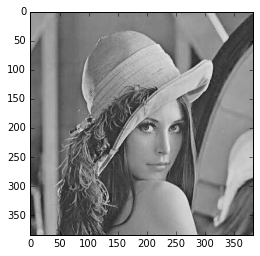

In [20]:
from scipy import misc
lenna = sp.ndimage.imread('lenna_bw.jpg')
print('- Original -')
plt.imshow(lenna,cmap='gray')
print('Dimensions: ',lenna.shape)

- Cropping -
Dimensions:  (84, 84)


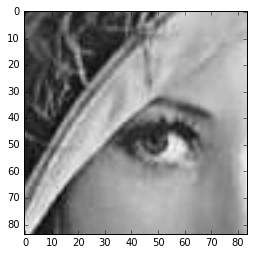

In [21]:
# cropping
a = 150
lenna = lenna[a:-a,a:-a,0]
del a
lenna = 0.1*lenna/np.max(lenna)
print('- Cropping -')
plt.imshow(lenna,cmap='gray')
print('Dimensions: ',lenna.shape)

In [ ]:
def downscale(inp,r):
    d = int(inp.shape[0]/r)
    outp = np.zeros([d,d])
    for i in range(d):
        for j in range(d):
            outp[i,j] = np.mean(inp[i*r:(i+1)*r,j*r:(j+1)*r])
    return outp
a = 2 #downscale factor
lenna = downscale(lenna,a)
del a
print('- Downscaling -')
plt.imshow(lenna,cmap='gray')
print('Dimensions: ',lenna.shape)

In [22]:
# reshape into vector
lenna_dim = lenna.shape[0]
lenna_vector = np.reshape(lenna,[lenna_dim**2,1])

In [23]:
tmp = np.eye(lenna_dim**2,lenna_dim**2)

In [ ]:
# blurring
A = np.dot(np.transpose(idm(lenna_dim**2,2)),idm(lenna_dim**2,2))
lenna_b = np.dot(A,lenna_vector)
print('- Blurred -')
plt.imshow(np.reshape(lenna_b,[lenna_dim,lenna_dim]),cmap='gray')

In [ ]:
# noise
lenna_n = lenna_b + np.random.randn(lenna_b.shape[0],lenna_b.shape[1])*max(lenna_b)/10
print('- Noisy -')
plt.imshow(np.reshape(lenna_n,[lenna_dim,lenna_dim]),cmap='gray')

In [ ]:
# total variation matrix
def TV(dim):
    M1 = np.eye(dim-1,dim,0)
    M2 = np.eye(dim-1,dim,1)
    return M1 - M2
# objective
def H(A,b,M):
    def h(u):
        return np.linalg.norm(np.dot(A,u)-b)**2 + np.sum(np.fabs(np.dot(M,u)))
    return h

In [ ]:
# actual problem
M = TV(lenna_dim**2)
h = H(A,lenna_n,M)

In [ ]:
# actual problem
M = np.zeros([lenna_dim**2,lenna_dim**2])
h = H(A,lenna_n,M)
print(M.shape)

In [ ]:
# prox operator
def prox(x):
    d = np.shape(x)
    y=x
    for j in range(0,d[0]):
        if x[j,0] > 1:
            y[j,0] = 1
            
        elif x[j,0] < -1:
            y[j,0] = -1
    return(y)

In [ ]:
# multi prox papc implementation for lenna tests
def papc(L,A,b,M,N,v0,u0,t,s,A2):
    
    # initialization
    v = v0
    u = u0
    u1 = u
    Mt = np.transpose(M)
    Ab = np.dot(np.transpose(A),b)
    U1 = []
    U = []


    # iterations
    for i in range(N):
        p = u
        for j in range(L):
            p = p-t*(np.dot(Mt,v) + 2*np.dot(A2,p) - 2*Ab )
            a = v + s*np.dot(M,p)
            v = prox(a)
        u = u-t*(np.dot(Mt,v) + 2*np.dot(A2,u) - 2*Ab )
        u1 = (u + i*u1)/(i+1)
        U.append(u)
        U1.append(u1)
        
    return{'U1':U1,'U':U}

In [ ]:
# PAPC preliminary
import time as time
t0 = time.time()
u0 = np.zeros(lenna_n.shape)
v0 = np.dot(M,u0)
A2 = np.dot(np.transpose(A),A)
t = 1/(2*np.linalg.norm(A2,2))
print('t:',t)
if t > 1:
    t = np.random.rand(1)
    print('t:',t)
t1 = time.time()
print('time:',t1 - t0)
s = t*(np.linalg.norm(M,2))**2
t2 = time.time()
print('\ns:',s,'\ntime:',t2-t1)

In [ ]:
# actual PAPC run
N = 200
t0 = time.time()
R = papc(1,A,lenna_b,M,N,v0,u0,t,s,A2)
print('papc\ntime:',time.time()-t0,'\n')

In [ ]:
U = R['U']
plt.imshow(np.reshape(U[0],[lenna_dim,lenna_dim]),cmap='gray')

In [ ]:
U = R['U']
plt.imshow(np.reshape(U[int(N/2)],[lenna_dim,lenna_dim]),cmap='gray')

In [ ]:
U = R['U']
plt.imshow(np.reshape(U[N-1],[lenna_dim,lenna_dim]),cmap='gray')

In [ ]:
U = R['U1']
plt.imshow(np.reshape(U[N-1],[lenna_dim,lenna_dim]),cmap='gray')

In [ ]:
# original
plt.imshow(np.reshape(lenna_orig,[lenna_dim,lenna_dim]),cmap='gray')

In [ ]:
U = R['U']
U1 = R['U1']
Y = np.zeros([N,1])
Z = np.zeros([N,1])
i = 0
for u in U:
    Y[i] = h(u)
    i = i + 1
plt.plot(Y)
i = 0
for u in U1:
    Z[i] = h(u)
    i = i + 1
plt.hold(True)
plt.plot(Z)
plt.legend(['Pure','Mean'])
#print(h(U[0]))
#print(h(U[N-1]))
#print(h(lenna_orig))

In [ ]:
U.shape

## Bibliography
[DST15] - A simple algorithm for a class of nonsmooth convex–concave saddle-point problems.
Teboulle M, Drori Y, Sabach S. Operation Research Letters 2015